# Overfitting, Underfitting, Early Stopping
В этом блокноте мы детально обсудим вопросы переобучения и недообучения, которые то и дело возникают на практике

Итак, давайте на практике поймем, как недообучение и переобучение выглядят в случае нейронных сетей, и что можно сделать для того, чтобы решать эти проблемы.
Как обычно, для начала проверим, что у нас установлены все необходимые нам пакеты, в том числе `seaborn` - пакет для визуализации, который мы будем использовать.

In [1]:
!pip install numpy tensorflow tensorflow_datasets seaborn pandas matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


Далее импортируем все пакеты, которые будем использовать.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics, layers, activations, optimizers, losses
import tensorflow_datasets as tfds
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18, 5)})

Для лучшей воспроизводимости данного ноутбука зафиксируем все `random seed`, которые могут использоваться.

In [4]:
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Мы будем использовать тот же самый набор данных «Ирисы Фишера», что и ранее, поэтому импортируем его и подготовим для работы ровно тем же способом, что и ранее.

In [5]:
ds_train, ds_test = tfds.load(
    name='iris',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True
)

input_shape = (4, )  
batch_size = 10      
amount_of_classes = 3

def make_one_hot(x, y):
    return x, tf.one_hot(y, depth=amount_of_classes)

ds_train = (
    ds_train
    .map(make_one_hot)
    .shuffle(len(ds_train))
    .batch(batch_size, drop_remainder=True)
)
    
ds_test = (
    ds_test
    .map(make_one_hot)
    .batch(batch_size, drop_remainder=True)
)

Metal device set to: Apple M1 Pro


2022-07-04 11:00:28.542436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-04 11:00:28.543156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Underfitting (недообучение) — это ситуация, когда модель, которой мы пытаемся приблизить искомую функцию, не обладает достаточными знаниями для адекватного описания набора данных. Вы наверняка уже сталкивались с данной ситуацией, работая ранее с другими моделями машинного обучения, например, пытаясь предсказать линейной функцией какие-либо сложные зависимости в данных.

В мире нейронных сетей данная ситуация тоже имеет место. Она возникает либо в случае недостаточно хорошей модели, либо в случае недостаточного времени обучения, да и много по каким еще причинам. Чтобы не быть голословными, давайте создадим сеть из двух слоев, в одном из которых только один нейрон. На выходе будет, конечно же, $3$ нейрона -- число, равное количеству классов.. Попытаемся обучить данную модель на нашем наборе данных.

In [6]:
model = keras.Sequential()
model.add(layers.Dense(1, input_shape=input_shape, activation='sigmoid'))
model.add(layers.Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

history = model.fit(ds_train, epochs=30, validation_data=ds_test, verbose=1)

Epoch 1/30


2022-07-04 11:03:23.042183: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-04 11:03:23.046616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 18ms/step - loss: 1.0457 - categorical_accuracy: 0.3250 - val_loss: 0.9859 - val_categorical_accuracy: 0.3667
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 0.9802 - categorical_accuracy: 0.4333 - val_loss: 0.9585 - val_categorical_accuracy: 0.6667
Epoch 3/30
 1/12 [=>............................] - ETA: 0s - loss: 0.9642 - categorical_accuracy: 0.4000

2022-07-04 11:03:23.954258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 11ms/step - loss: 0.9496 - categorical_accuracy: 0.6417 - val_loss: 0.9295 - val_categorical_accuracy: 0.6000
Epoch 4/30
12/12 [==============================] - 0s 8ms/step - loss: 0.9174 - categorical_accuracy: 0.5167 - val_loss: 0.9004 - val_categorical_accuracy: 0.6333
Epoch 5/30
12/12 [==============================] - 0s 8ms/step - loss: 0.8856 - categorical_accuracy: 0.4417 - val_loss: 0.8733 - val_categorical_accuracy: 0.5000
Epoch 6/30
12/12 [==============================] - 0s 8ms/step - loss: 0.8580 - categorical_accuracy: 0.6750 - val_loss: 0.8477 - val_categorical_accuracy: 0.6333
Epoch 7/30
12/12 [==============================] - 0s 8ms/step - loss: 0.8292 - categorical_accuracy: 0.6750 - val_loss: 0.8225 - val_categorical_accuracy: 0.6333
Epoch 8/30
12/12 [==============================] - 0s 8ms/step - loss: 0.8040 - categorical_accuracy: 0.6750 - val_loss: 0.8004 - val_categorical_accuracy: 0.6333
Epoch 9/30
12/12 [========

Визуализируем графики значений функции потерь и точности. Для этого преобразуем историю обучения в новый датафрейм и построим соответствующие графики.

(0.0, 1.0)

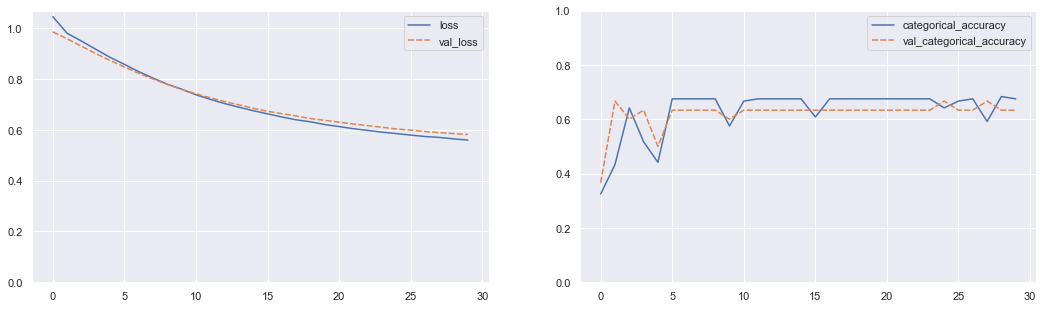

In [7]:
df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax.set_ylim(0)

ax = sns.lineplot(data=df[['categorical_accuracy', 'val_categorical_accuracy']], ax=axes[1])
ax.set_ylim(0, 1)

Как можно заметить, точность модели достигла примерно 0.7 на тренировочном и валидационном наборе данных. Ранее в данном курсе мы с вами видели, что модель может достигать более высокого качества, и в данном случае мы с вами наблюдам ситуацию недообучения модели. Обратите внимание на поведение графиков функции потерь на тренировочном и валидационном наборах: они очень близки и уменьшаются сообща.

Для того чтобы решить проблему недообучения, в данном случае правильным решением будет постепенно увеличивать сложность сети, наращивая ее глубину и мощность, тем самым повышая качество полученной модели.

Тем не менее, если мы попробуем сразу использовать слишком сложную сеть, мы можем столкнуться с фактом переобучения модели. Несмотря на то, что на таком простом наборе данных этого достичь достаточно сложно, давайте попробуем изголиться.

In [8]:
model = keras.Sequential()
model.add(layers.Dense(128, input_shape=input_shape, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)


history = model.fit(ds_train, epochs=60, validation_data=ds_test, verbose=1)

Epoch 1/60
 8/12 [===================>..........] - ETA: 0s - loss: 1.1161 - categorical_accuracy: 0.3250

2022-07-04 11:05:25.750750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 16ms/step - loss: 1.1086 - categorical_accuracy: 0.3417 - val_loss: 1.1045 - val_categorical_accuracy: 0.3000
Epoch 2/60
12/12 [==============================] - 0s 10ms/step - loss: 1.1010 - categorical_accuracy: 0.3417 - val_loss: 1.1031 - val_categorical_accuracy: 0.3000
Epoch 3/60
 1/12 [=>............................] - ETA: 0s - loss: 1.1434 - categorical_accuracy: 0.1000

2022-07-04 11:05:25.983625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 10ms/step - loss: 1.1023 - categorical_accuracy: 0.2833 - val_loss: 1.0929 - val_categorical_accuracy: 0.3667
Epoch 4/60
12/12 [==============================] - 0s 10ms/step - loss: 1.0953 - categorical_accuracy: 0.3250 - val_loss: 1.0915 - val_categorical_accuracy: 0.6667
Epoch 5/60
12/12 [==============================] - 0s 11ms/step - loss: 1.0908 - categorical_accuracy: 0.6833 - val_loss: 1.0914 - val_categorical_accuracy: 0.6333
Epoch 6/60
12/12 [==============================] - 0s 9ms/step - loss: 1.0870 - categorical_accuracy: 0.6750 - val_loss: 1.0876 - val_categorical_accuracy: 0.6333
Epoch 7/60
12/12 [==============================] - 0s 9ms/step - loss: 1.0847 - categorical_accuracy: 0.6750 - val_loss: 1.0852 - val_categorical_accuracy: 0.6333
Epoch 8/60
12/12 [==============================] - 0s 9ms/step - loss: 1.0788 - categorical_accuracy: 0.4833 - val_loss: 1.0745 - val_categorical_accuracy: 0.4667
Epoch 9/60
12/12 [======

Аналогичным образом визуализируем полученные результаты.

(0.0, 1.0)

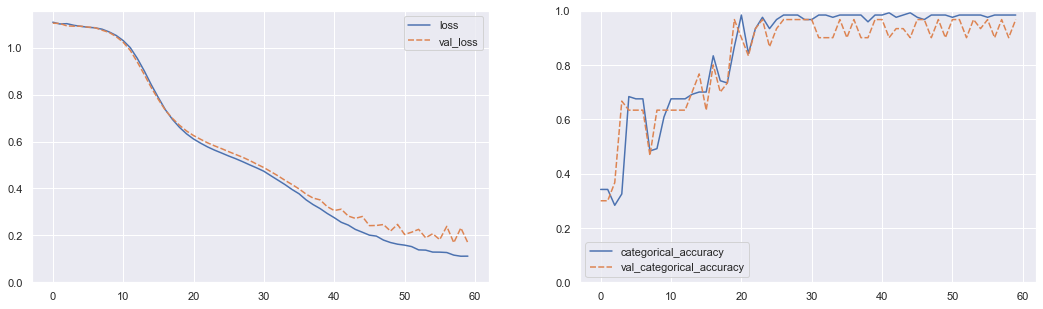

In [9]:
df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax.set_ylim(0)

ax = sns.lineplot(data=df[['categorical_accuracy', 'val_categorical_accuracy']], ax=axes[1])
ax.set_ylim(0, 1)

Как можно заметить, в какой-то момент точность нашей модели на тренировочной выборке стала больше, чем на валидационной. В зависимости от величины расхождения, это - один из хороших показателей того, что ваша модель переобучается. Переобучение, как и в классическом машинном обучении, может привести к тому, что модель запомнит обучающий набор данных и потеряет генерализующую способность, то есть не сможет адекватно оценивать и корректно классифицировать новые экземпляры данных, которые она до этого не видела.

В нейронных сетях кроме метрик на тренировочном и валидационном наборе данных также хорошим показателем того, произошло ли переобучение модели, является график функции потерь. До тех пор, пока график функции потерь на валидационном наборе данных является ниспадающим, модель учится и находит зависимости в данных, которые полезны для всего набора данных.

В момент, когда графики функций потерь тренировочного и валидационного набора данных начинают расходиться, дальнейшее обучение менее полезно с точки зрения генерализующей способности, так как модель, вместо того чтобы обобщать, начинает выучивать данные, что выражается в том, что на тренировочном наборе данных значение функции потерь продолжает падать, а на валидационном — нет. Это можно заметить на текущем графике функций потерь.

В дальнейшем, при продолжении обучения, возможна следующая ситуация: значения функции потерь на тренировочном наборе данных продолжают падать, а на валидационном начинают расти. В этот момент модель «начала учиться не туда» — модель начинает терять генерализующую способность, и в этот момент уже точно стоит прекратить обучение.

Таким образом, одним из оптимальных решений будет остановка обучения в тот момент, когда значение функции потерь на валидационном наборе данных перестанет снижаться. В фреймворке Keras для этого присутствует `EarlyStopping Callback` — специальный объект, который останавливает обучение при выполнении данного условия. Кроме него, в фреймворке присутсвует еще множество других callback'ов, на которые стоит обратить внимание. Например, промежуточное сохранение модели в процессе обучения для гарантии того, что результат не потеряется в случае перебоев питания компьютера, или callback отсылки информации на удаленный сервер.

Инициализируем `EarlyStoppingCallback`, укажем `val_loss` как значения для мониторинга и запустим процесс обучения предыдущей модели заново.

2022-07-04 11:09:30.002694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-04 11:09:30.196533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epochs executed: 55


(0.0, 1.0)

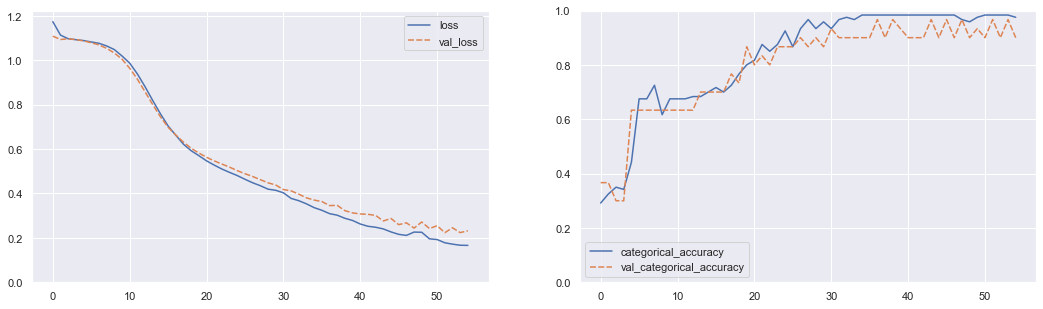

In [10]:
esc = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = keras.Sequential()
model.add(layers.Dense(128, input_shape=input_shape, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(amount_of_classes, activation='softmax'))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)


history = model.fit(ds_train, epochs=90, validation_data=ds_test, verbose=0, callbacks=[esc])
print(f"Epochs executed: {len(history.epoch)}")

df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 2)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
ax.set_ylim(0)

ax = sns.lineplot(data=df[['categorical_accuracy', 'val_categorical_accuracy']], ax=axes[1])
ax.set_ylim(0, 1)

Можно заметить, что обучение остановилось в тот момент, когда значение функции потерь на валидационном наборе данных 3 раза (т.к. был указан `patience=3`) не снижалось. Итак, мы смогли поймать ровно тот момент, когда обучение стоит прекратить.
